### **Problem Statement**
The goal of this part of the project is to develop a predictive machine learning model that can assess accident severity based on a variety of factors such as weather conditions, traffic levels, road types, and environmental variables. The model will predict accident severity (Fatal, Serious, Slight) at specific locations by leveraging historical accident data, providing critical insights for enhancing road safety, particularly for autonomous vehicles. The prediction model will then be integrated into a real-time system that simulates a vehicle's journey between two points, dynamically predicting accident-prone areas along the route and issuing timely alerts to avoid potential hazards. This solution aims to enhance driver safety and improve decision-making for autonomous navigation systems.

### **Import Libraries**

In [1]:
#import required libraries
from google.colab import drive
import gspread
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from google.colab import auth
from google.auth import default
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files
from imblearn.over_sampling import SMOTE
import json
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

### **Open and Load Historical Data as DataFrame**

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the path to your CSV file
csv_path = '/content/drive/MyDrive/thesis/Road_Accident_Data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
df.head()

,Accident_Index,Accident Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority_(District),Carriageway_Hazards,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,BS0000001,1/1/2021,Thursday,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,One way street,30,15:11,Urban,Fine no high winds,Car
1,BS0000002,1/5/2021,Monday,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,Kensington and Chelsea,NaN,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59,Urban,Fine no high winds,Taxi/Private hire car
2,BS0000003,1/4/2021,Sunday,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19,Urban,Fine no high winds,Taxi/Private hire car
3,BS0000004,1/5/2021,Monday,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,8:10,Urban,Other,Motorcycle over 500cc
4,BS0000005,1/6/2021,Tuesday,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25,Urban,Fine no high winds,Car


## Preprocessing the Data

In [4]:
print("No. of rows: {}".format(df.shape[0]))
print("No. of cols: {}".format(df.shape[1]))

No. of rows: 307973
No. of cols: 21


In [5]:
df.columns

Index(['Accident_Index', 'Accident Date', 'Day_of_Week', 'Junction_Control',
       'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type'],
      dtype='object')

In [6]:
# Clean the header names
df1 = df.copy()
df1.rename(columns={'Local_Authority_(District)': 'Local_Authority', 'Accident Date': 'Accident_Date'}, inplace=True)

In [73]:
df1.head(5)

,Accident_Index,Accident_Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority,Carriageway_Hazards,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,BS0000001,1/1/2021,Thursday,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,One way street,30,15:11,Urban,Fine no high winds,Car
1,BS0000002,1/5/2021,Monday,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,Kensington and Chelsea,NaN,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59,Urban,Fine no high winds,Taxi/Private hire car
2,BS0000003,1/4/2021,Sunday,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19,Urban,Fine no high winds,Taxi/Private hire car
3,BS0000004,1/5/2021,Monday,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,8:10,Urban,Other,Motorcycle over 500cc
4,BS0000005,1/6/2021,Tuesday,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25,Urban,Fine no high winds,Car


In [8]:
# Check and clean the Target variable
accident_severity = df1['Accident_Severity'].unique()
for value in accident_severity:
  print (value)

Serious
Slight
Fetal
Fatal


In [9]:
# Replace "Fetal" with "Fatal" in the Accident_Severity column
df2 = df1.copy()
df2['Accident_Severity'] = df2['Accident_Severity'].replace("Fetal", "Fatal")

### Explore the relationship of the Target variable and other features

In [10]:
# 1. Number of Accidents based on the Weather_Conditions
df2.Weather_Conditions.value_counts().sort_values(ascending=False).head(20)

,count
Weather_Conditions,
Fine no high winds,244496
Raining no high winds,37841
Other,8802
Snowing no high winds,4839
Fog or mist,4783
Raining + high winds,3526
Fine + high winds,3148
Snowing + high winds,538


In [11]:
# 2. Number of Accidents based on the Road_Type
df2.Road_Type.value_counts().sort_values(ascending=False).head(20)

,count
Road_Type,
Single carriageway,230612
Dual carriageway,45467
Roundabout,20929
One way street,6197
Slip road,4768


In [12]:
# 2. Number of Accidents based on the Road_Type
df2.Road_Surface_Conditions.value_counts().sort_values(ascending=False).head(20)

,count
Road_Surface_Conditions,
Dry,208967
Wet or damp,81796
Frost or ice,12078
Snow,4758
Flood over 3cm. deep,374


In [13]:
# 3. Number of Accidents based on the Speed_limit
df2.Speed_limit.value_counts().sort_values(ascending=False).head(20)

,count
Speed_limit,
30,200040
60,46826
40,25650
70,22362
50,10191
20,2899
10,3
15,2


In [14]:
# 4. Number of Accidents based on the Junction Control
df2.Junction_Control.value_counts().sort_values(ascending=False).head(20)

,count
Junction_Control,
Give way or uncontrolled,150045
Data missing or out of range,98056
Auto traffic signal,32256
Not at junction or within 20 metres,25378
Stop sign,1685
Authorised person,460
Auto traffic sigl,93


In [15]:
# Count the number of Accidents Severities based on Junction Control.
# Step 1: Group by Junction_Detail and Accident_Severity, and count the occurrences
severity_counts = df2.groupby(['Junction_Control', 'Accident_Severity']).size()

# Step 2: Unstack the data to have Accident_Severity as columns
severity_counts = severity_counts.unstack(fill_value=0)

# Step 3: Optionally, add a total count column if needed
severity_counts['Total'] = severity_counts.sum(axis=1)

# Step 4: Sort by the total or specific severity types
sorted_severity_counts = severity_counts.sort_values(by='Total', ascending=False)

# Display the sorted result
print("Accidents distribution based on Junction Control:")
print(sorted_severity_counts.head(20))

Accidents distribution based on Junction Control:
Accident_Severity                    Fatal  Serious  Slight   Total
Junction_Control                                                   
Give way or uncontrolled              1223    18237  130585  150045
Data missing or out of range          1916    15012   81128   98056
Auto traffic signal                    302     3274   28680   32256
Not at junction or within 20 metres    499     3990   20889   25378
Stop sign                               11      175    1499    1685
Authorised person                        2       42     416     460
Auto traffic sigl                        0       10      83      93


In [16]:
# 5. Number of Accidents based on the Junction Detail
df2.Junction_Detail.value_counts().sort_values(ascending=False).head(20)

,count
Junction_Detail,
Not at junction or within 20 metres,123094
T or staggered junction,96718
Crossroads,29948
Roundabout,27264
Private drive or entrance,10875
Other junction,8315
Slip road,4265
More than 4 arms (not roundabout),4148
Mini-roundabout,3346


In [17]:
# Count the number of Accident Types based on the Accident Severity.
# Step 1: Group by Junction_Detail and Accident_Severity, and count the occurrences
severity_counts = df2.groupby(['Junction_Detail', 'Accident_Severity']).size()

# Step 2: Unstack the data to have Accident_Severity as columns
severity_counts = severity_counts.unstack(fill_value=0)

# Step 3: Optionally, add a total count column if needed
severity_counts['Total'] = severity_counts.sum(axis=1)

# Step 4: Sort by the total or specific severity types
sorted_severity_counts = severity_counts.sort_values(by='Total', ascending=False)

# Display the sorted result
print(sorted_severity_counts.head(20))

Accident_Severity                    Fatal  Serious  Slight   Total
Junction_Detail                                                    
Not at junction or within 20 metres   2412    18964  101718  123094
T or staggered junction                886    12341   83491   96718
Crossroads                             308     3528   26112   29948
Roundabout                              92     2236   24936   27264
Private drive or entrance               97     1451    9327   10875
Other junction                          62      991    7262    8315
Slip road                               54      480    3731    4265
More than 4 arms (not roundabout)       30      455    3663    4148
Mini-roundabout                         12      294    3040    3346


In [18]:
# 6. Number of Accidents based on the Vehicle Type
df2.Vehicle_Type.value_counts().sort_values(ascending=False).head(20)

,count
Vehicle_Type,
Car,239794
Van / Goods 3.5 tonnes mgw or under,15695
Motorcycle over 500cc,11226
Bus or coach (17 or more pass seats),8686
Motorcycle 125cc and under,6852
Goods 7.5 tonnes mgw and over,6532
Taxi/Private hire car,5543
Motorcycle 50cc and under,3703
Motorcycle over 125cc and up to 500cc,3285


In [19]:
# Count the number of Accident Severities based on the Vehicle Types.
# Step 1: Group by Junction_Detail and Accident_Severity, and count the occurrences
severity_counts = df2.groupby(['Vehicle_Type', 'Accident_Severity']).size()

# Step 2: Unstack the data to have Accident_Severity as columns
severity_counts = severity_counts.unstack(fill_value=0)

# Step 3: Optionally, add a total count column if needed
severity_counts['Total'] = severity_counts.sum(axis=1)

# Step 4: Sort by the total or specific severity types
sorted_severity_counts = severity_counts.sort_values(by='Total', ascending=False)

# Display the sorted result
print("Accidents distribution based on Vehicle types:")
print(sorted_severity_counts.head(20))

Accidents distribution based on Vehicle types:
Accident_Severity                      Fatal  Serious  Slight   Total
Vehicle_Type                                                         
Car                                     3132    31583  205079  239794
Van / Goods 3.5 tonnes mgw or under      210     2121   13364   15695
Motorcycle over 500cc                    143     1496    9587   11226
Bus or coach (17 or more pass seats)      86     1135    7465    8686
Motorcycle 125cc and under                81      926    5845    6852
Goods 7.5 tonnes mgw and over             67      878    5587    6532
Taxi/Private hire car                     59      742    4742    5543
Motorcycle 50cc and under                 43      501    3159    3703
Motorcycle over 125cc and up to 500cc     49      414    2822    3285
Other vehicle                             34      355    2127    2516
Goods over 3.5t. and under 7.5t           31      352    2119    2502
Minibus (8 - 16 passenger seats)          1

In [20]:
# 4. Accident severity based on the Urban or Rural and Light Conditions
df2.Light_Conditions.value_counts().sort_values(ascending=False).head(20)

,count
Light_Conditions,
Daylight,227286
Darkness - lights lit,60093
Darkness - no lighting,16528
Darkness - lighting unknown,2924
Darkness - lights unlit,1142


In [21]:
# Accident severity based on the Urban Area during the Night
# Step 1: Filter the DataFrame based on Urban_or_Rural_Area and Time
filtered_df = df2[(df2['Urban_or_Rural_Area'] == 'Urban') & (df2['Light_Conditions'] == 'Darkness - no lighting')]

# Step 2: Group by Junction_Detail, Accident_Severity, Urban_or_Rural_Area, and Time
severity_counts = filtered_df.groupby(['Junction_Detail', 'Accident_Severity']).size()

# Step 3: Unstack the data to have Accident_Severity as columns
severity_counts = severity_counts.unstack(fill_value=0)

# Step 4: Optionally, add a total count column if needed
severity_counts['Total'] = severity_counts.sum(axis=1)

# Step 5: Sort by the total or specific severity types
sorted_severity_counts = severity_counts.sort_values(by='Total', ascending=False)

# Display the sorted result
print("Accidents distribution in urban areas during the night:")
print(sorted_severity_counts.head(20))

Accidents distribution in urban areas during the night:
Accident_Severity                    Fatal  Serious  Slight  Total
Junction_Detail                                                   
Not at junction or within 20 metres     17       84     413    514
T or staggered junction                  0       21     143    164
Crossroads                               0        5      34     39
Roundabout                               0        2      25     27
Private drive or entrance                0        7      18     25
Slip road                                0        3      21     24
Other junction                           0        3      13     16
Mini-roundabout                          0        0       6      6
More than 4 arms (not roundabout)        0        1       3      4


In [22]:
# Accident severity based on the Urban Area during the Day
# Step 1: Filter the DataFrame based on Urban_or_Rural_Area and Time
filtered_df = df2[(df2['Urban_or_Rural_Area'] == 'Urban') & (df2['Light_Conditions'] == 'Daylight')]

# Step 2: Group by Junction_Detail, Accident_Severity, Urban_or_Rural_Area, and Time
severity_counts = filtered_df.groupby(['Junction_Detail', 'Accident_Severity']).size()

# Step 3: Unstack the data to have Accident_Severity as columns
severity_counts = severity_counts.unstack(fill_value=0)

# Step 4: Optionally, add a total count column if needed
severity_counts['Total'] = severity_counts.sum(axis=1)

# Step 5: Sort by the total or specific severity types
sorted_severity_counts = severity_counts.sort_values(by='Total', ascending=False)

# Display the sorted result
print("Accidents distribution in urban areas during the night:")
print(sorted_severity_counts.head(20))

Accidents distribution in urban areas during the night:
Accident_Severity                    Fatal  Serious  Slight  Total
Junction_Detail                                                   
T or staggered junction                361     6380   49997  56738
Not at junction or within 20 metres    354     5568   37645  43567
Crossroads                             133     1924   16100  18157
Roundabout                              40      916   11418  12374
Private drive or entrance               30      600    5073   5703
Other junction                          11      427    3795   4233
More than 4 arms (not roundabout)       13      253    2254   2520
Mini-roundabout                          6      171    1924   2101
Slip road                                9       92    1013   1114


In [23]:
# 5. Accident severity based on the Local Authority
df2.Local_Authority.value_counts().sort_values(ascending=False).head(20)

,count
Local_Authority,
Birmingham,6165
Leeds,4140
Manchester,3132
Bradford,3006
Westminster,2811
Sheffield,2750
Liverpool,2611
Cornwall,2606
Barnet,2302


In [24]:
# Accident severity in Liverpool Area during the Day
# Step 1: Filter the DataFrame based on Urban_or_Rural_Area and Time
filtered_df = df2[(df2['Local_Authority'] == 'Liverpool') & (df2['Light_Conditions'] == 'Daylight')]

# Step 2: Group by Junction_Control, Accident_Severity, Urban_or_Rural_Area, and Time
severity_counts = filtered_df.groupby(['Junction_Control', 'Accident_Severity']).size()

# Step 3: Unstack the data to have Accident_Severity as columns
severity_counts = severity_counts.unstack(fill_value=0)

# Step 4: Optionally, add a total count column if needed
severity_counts['Total'] = severity_counts.sum(axis=1)

# Step 5: Sort by the total or specific severity types
sorted_severity_counts = severity_counts.sort_values(by='Total', ascending=False)

# Display the sorted result
print("Accidents distribution based on Junction Control in Liverpool during the day:")
print(sorted_severity_counts.head(20))

Accidents distribution based on Junction Control in Liverpool during the day:
Accident_Severity             Fatal  Serious  Slight  Total
Junction_Control                                           
Give way or uncontrolled          5      128     866    999
Auto traffic signal               7       49     433    489
Data missing or out of range      2       74     334    410
Authorised person                 0        0       4      4
Stop sign                         0        0       1      1


In [25]:
# Accident severity in Birmingham
# Step 1: Filter the DataFrame based on Urban_or_Rural_Area and Time
filtered_df = df2[(df2['Local_Authority'] == 'Birmingham')]

# Step 2: Group by Junction_Detail, Accident_Severity, Urban_or_Rural_Area, and Time
severity_counts = filtered_df.groupby(['Junction_Detail', 'Accident_Severity']).size()

# Step 3: Unstack the data to have Accident_Severity as columns
severity_counts = severity_counts.unstack(fill_value=0)

# Step 4: Optionally, add a total count column if needed
severity_counts['Total'] = severity_counts.sum(axis=1)

# Step 5: Sort by the total or specific severity types
sorted_severity_counts = severity_counts.sort_values(by='Total', ascending=False)

# Display the sorted result
print("Accidents distribution in Birmingham:")
print(sorted_severity_counts.head(20))

Accidents distribution in Birmingham:
Accident_Severity                    Fatal  Serious  Slight  Total
Junction_Detail                                                   
T or staggered junction                 14      210    1676   1900
Not at junction or within 20 metres     24      288    1564   1876
Crossroads                              11      113     998   1122
Roundabout                               4       51     676    731
Private drive or entrance                4       26     305    335
Mini-roundabout                          0        8      83     91
More than 4 arms (not roundabout)        0        8      46     54
Slip road                                0        1      39     40
Other junction                           0        1      15     16


### Data Cleaning

In [26]:
df3 = df2.copy()

In [27]:
# Getting Features' information
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307973 entries, 0 to 307972
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Accident_Index           307973 non-null  object 
 1   Accident_Date            307973 non-null  object 
 2   Day_of_Week              307973 non-null  object 
 3   Junction_Control         307973 non-null  object 
 4   Junction_Detail          307973 non-null  object 
 5   Accident_Severity        307973 non-null  object 
 6   Latitude                 307973 non-null  float64
 7   Light_Conditions         307973 non-null  object 
 8   Local_Authority          307973 non-null  object 
 9   Carriageway_Hazards      5424 non-null    object 
 10  Longitude                307973 non-null  float64
 11  Number_of_Casualties     307973 non-null  int64  
 12  Number_of_Vehicles       307973 non-null  int64  
 13  Police_Force             307973 non-null  object 
 14  Road

In [28]:
# Checking for Nul values
df3.isna().any()

,0
Accident_Index,False
Accident_Date,False
Day_of_Week,False
Junction_Control,False
Junction_Detail,False
Accident_Severity,False
Latitude,False
Light_Conditions,False
Local_Authority,False
Carriageway_Hazards,True


In [29]:
# Number of null values in each feature
df3.isna().sum()

,0
Accident_Index,0
Accident_Date,0
Day_of_Week,0
Junction_Control,0
Junction_Detail,0
Accident_Severity,0
Latitude,0
Light_Conditions,0
Local_Authority,0
Carriageway_Hazards,302549


In [30]:
# Percentage of Null values in each feature
df3.isnull().sum() / len(df3) * 100

,0
Accident_Index,0.000000
Accident_Date,0.000000
Day_of_Week,0.000000
Junction_Control,0.000000
Junction_Detail,0.000000
Accident_Severity,0.000000
Latitude,0.000000
Light_Conditions,0.000000
Local_Authority,0.000000
Carriageway_Hazards,98.238807


In [31]:
df4 = df3.copy()

In [32]:
# Checking the distribution of the values
df4.Carriageway_Hazards.value_counts().sort_values(ascending=False).head(20)

,count
Carriageway_Hazards,
Other object on road,2243
Any animal in carriageway (except ridden horse),1620
Pedestrian in carriageway - not injured,715
Previous accident,511
Vehicle load on road,335


In [33]:
# Fill the Nulls with Zeros as there is not any helpful dominant value
df4['Carriageway_Hazards'].fillna(0, inplace=True)

<ipython-input-33-e0d2bd0bf886>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df4['Carriageway_Hazards'].fillna(0, inplace=True)


In [34]:
# Drop the Nulls, if the number is very less compared to the row
df5 = df4.copy()

df5.dropna(subset=['Time'], inplace=True)

In [35]:
# Now, let's see the number of rows and columns that we have after dropping the null-contained rows
print("No. of rows: {}".format(df5.shape[0]))
print("No. of cols: {}".format(df5.shape[1]))

No. of rows: 307956
No. of cols: 21


In [36]:
# Check for duplicated rows
dup_rows = df5[df5.duplicated()]
print("No. of duplicate rows: ", dup_rows.shape[0])

No. of duplicate rows:  0


In [37]:
numerical_data = df5.select_dtypes(include='number')
numerical_cols = numerical_data.columns
len(numerical_cols)

5

In [38]:
categorical_data = df5.select_dtypes(include='object')
categorical_cols = categorical_data.columns
len(categorical_cols)

16

### Data Visualization and Statistical Summaries

In [39]:
# Understanding statistical summaries of Numerical Data
df5.describe(include=np.number)

,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Speed_limit
count,307956.000000,307956.000000,307956.000000,307956.000000,307956.000000
mean,52.486758,-1.368811,1.356889,1.829066,38.865715
std,1.338630,1.356082,0.815869,0.710466,14.032765
min,49.914488,-7.516225,1.000000,1.000000,10.000000
25%,51.485234,-2.247849,1.000000,1.000000,30.000000
50%,52.225810,-1.349160,1.000000,2.000000,30.000000
75%,53.415420,-0.206801,1.000000,2.000000,50.000000
max,60.598055,1.759398,48.000000,32.000000,70.000000


In [40]:
# Understanding statistical summaries of Categorical Data
df5.describe(include=object)

,Accident_Index,Accident_Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Light_Conditions,Local_Authority,Carriageway_Hazards,Police_Force,Road_Surface_Conditions,Road_Type,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
count,307956,307956,307956,307956,307956,307956,307956,307956,307956,307956,307956,307956,307956,307956,307956,307956
unique,307956,730,7,7,9,3,5,422,6,51,5,5,1439,2,8,15
top,BS0000001,11/13/2021,Friday,Give way or uncontrolled,Not at junction or within 20 metres,Slight,Daylight,Birmingham,0,Metropolitan Police,Dry,Single carriageway,17:00,Urban,Fine no high winds,Car
freq,1,692,50529,150039,123086,263265,227275,6165,302532,46789,208961,230596,2933,198526,244484,239781


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

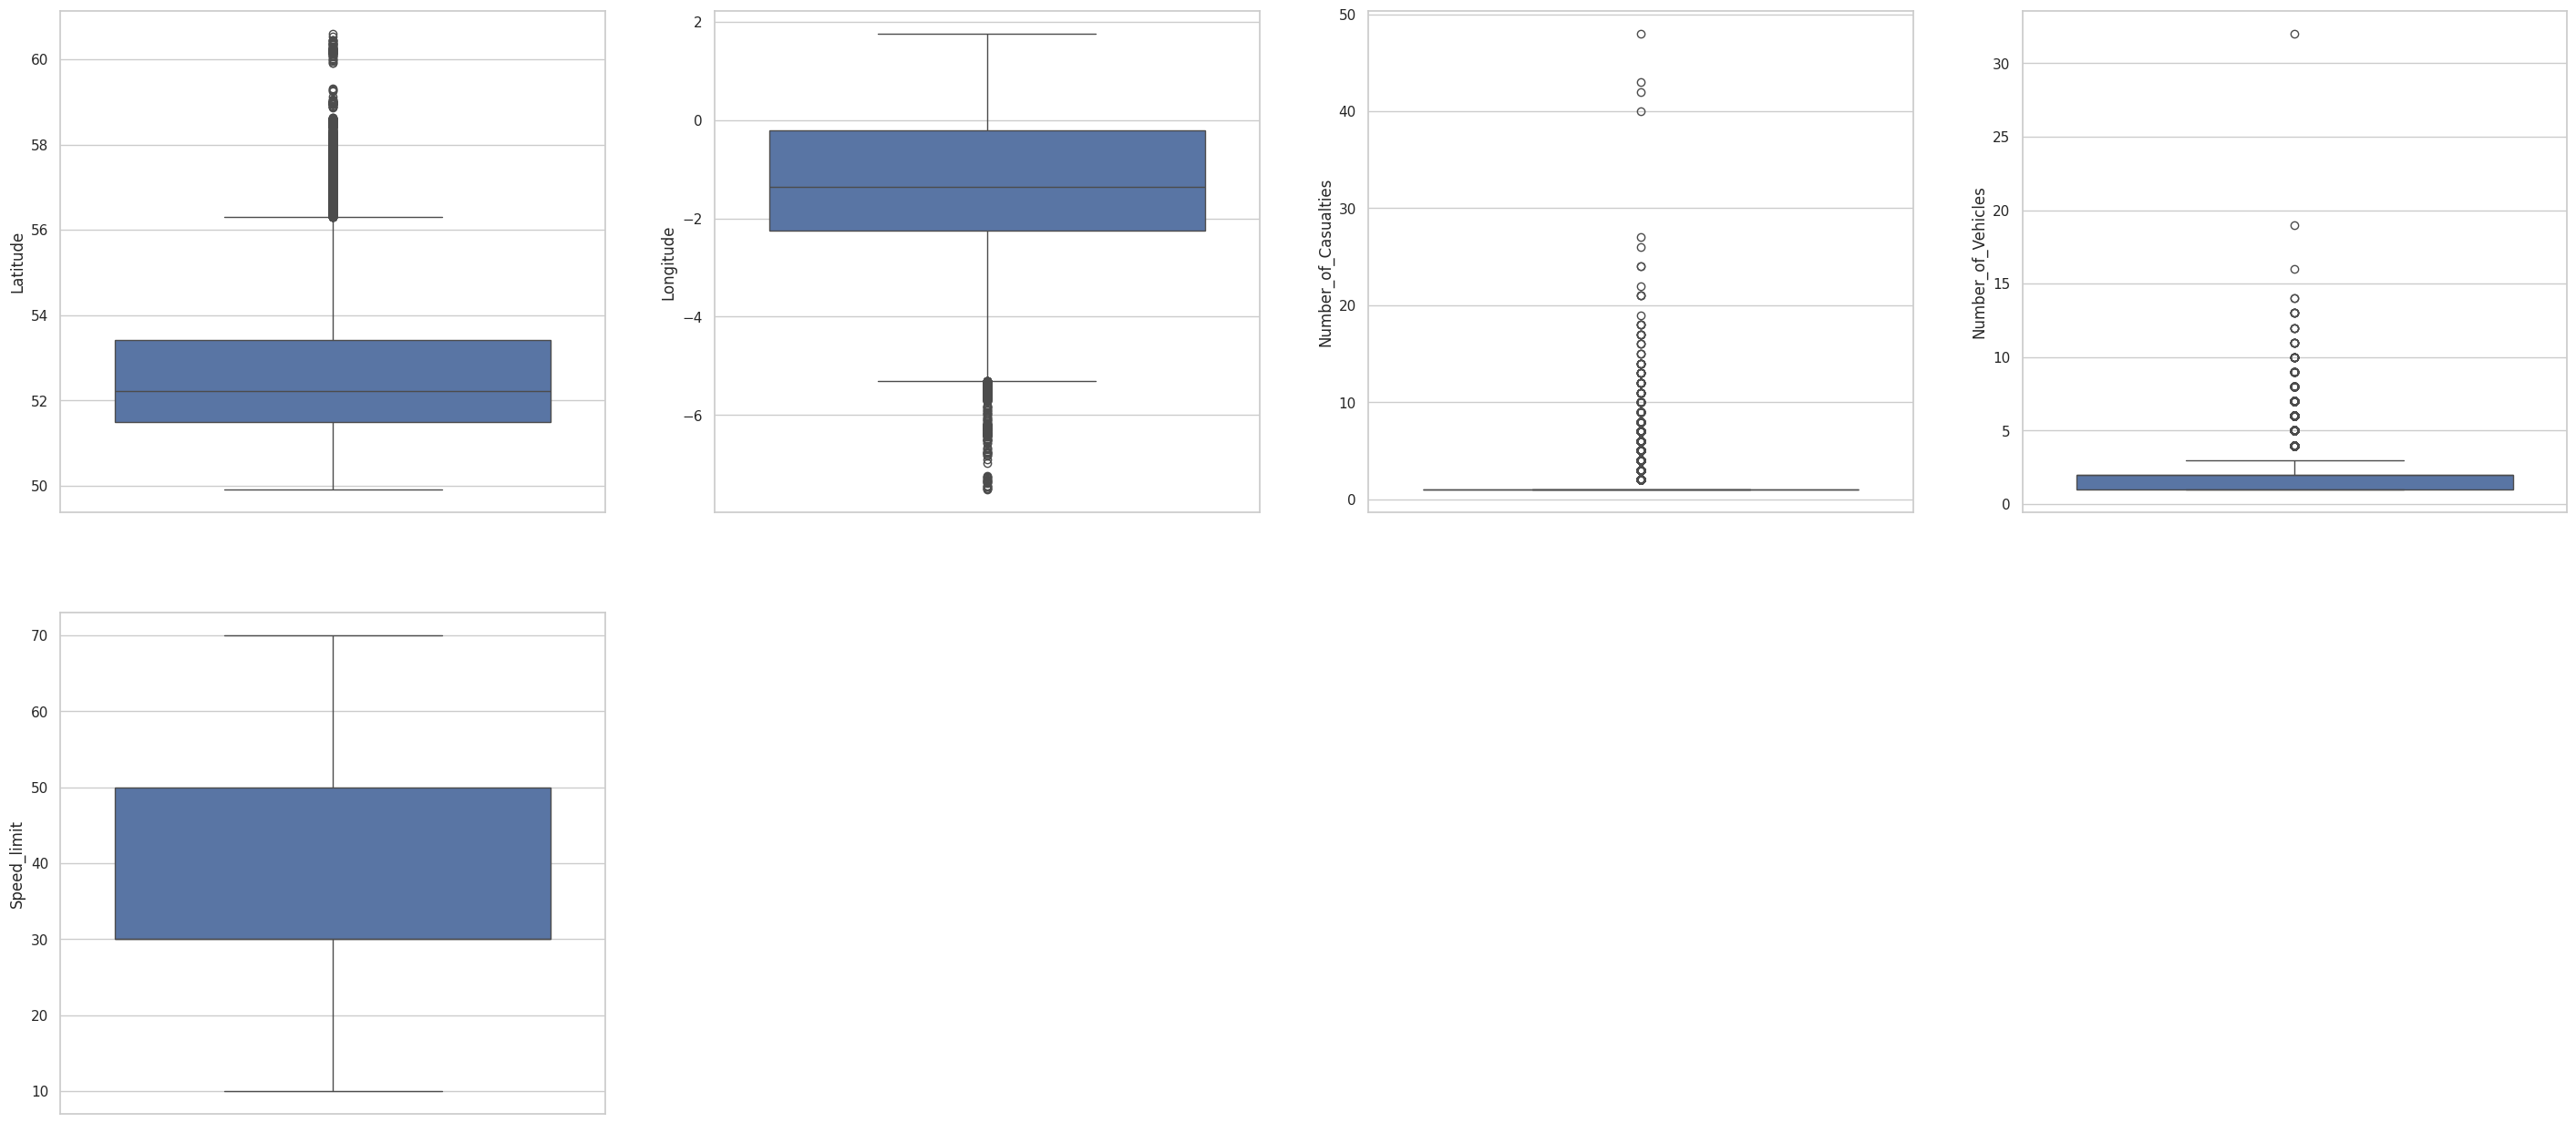

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [41]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(20, 50))
fig.subplots_adjust(right=1.5)

for plot in range(1, len(numerical_cols)+1):
    plt.subplot(6, 4, plot)
    sns.boxplot(y=df[numerical_cols[plot-1]])

plt.show()
%time

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

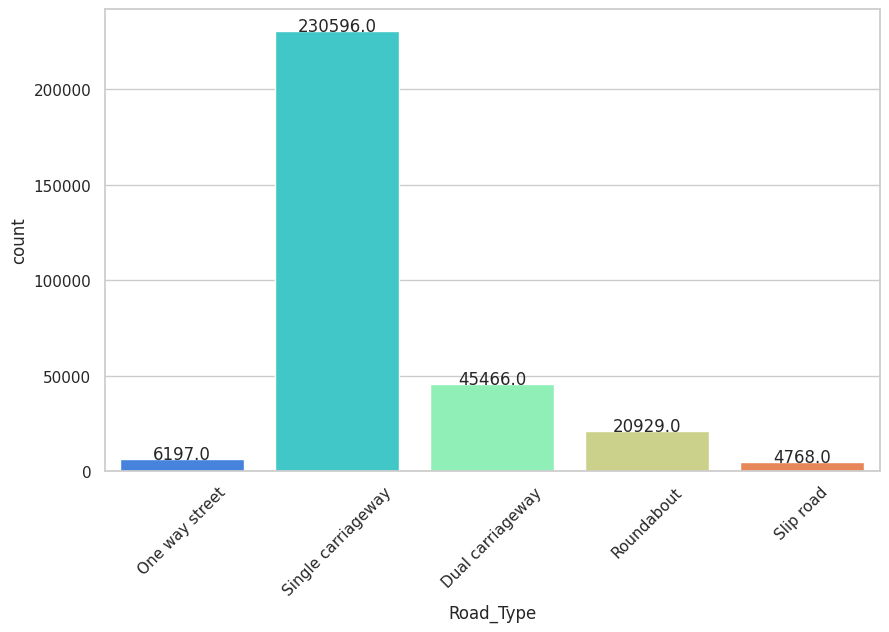

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

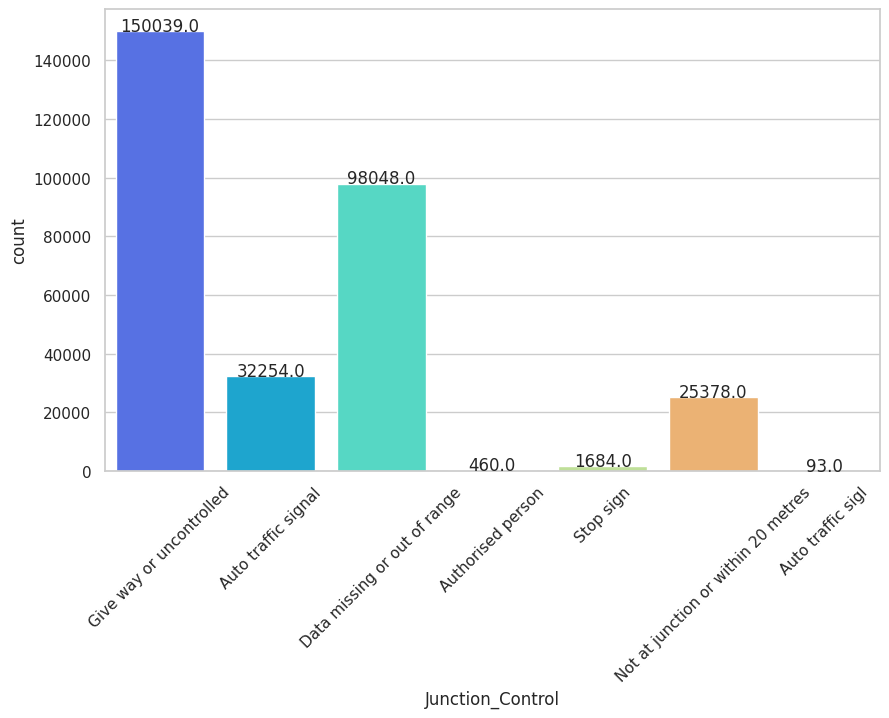

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

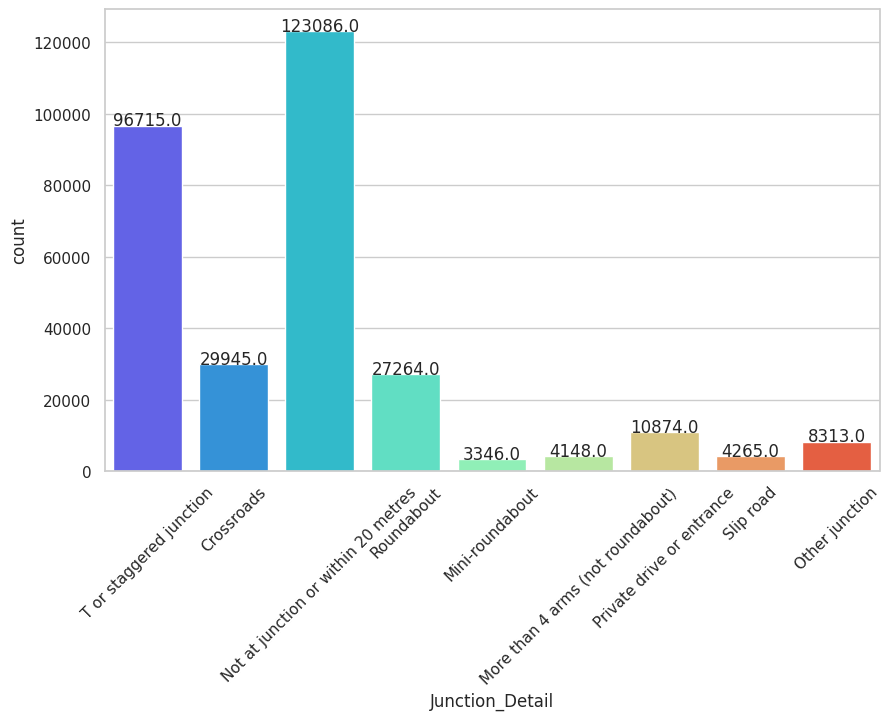

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


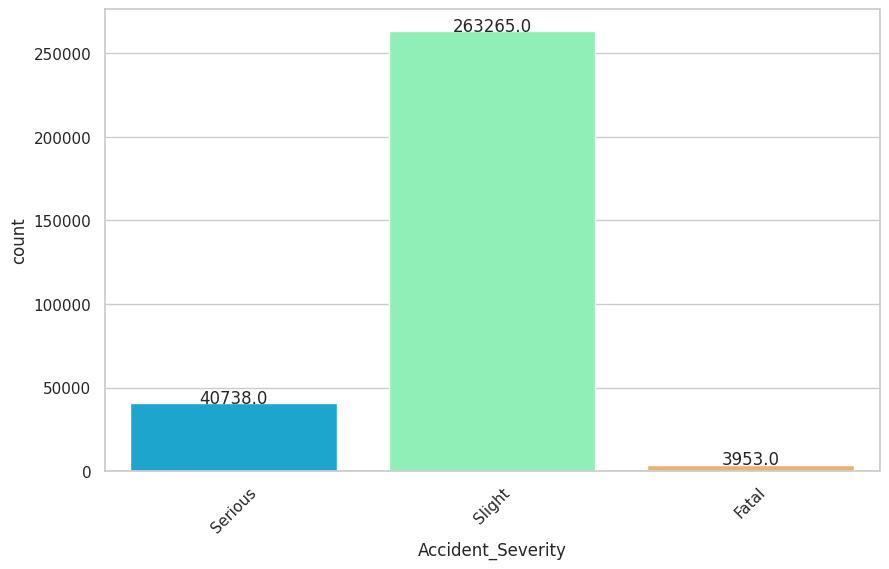

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

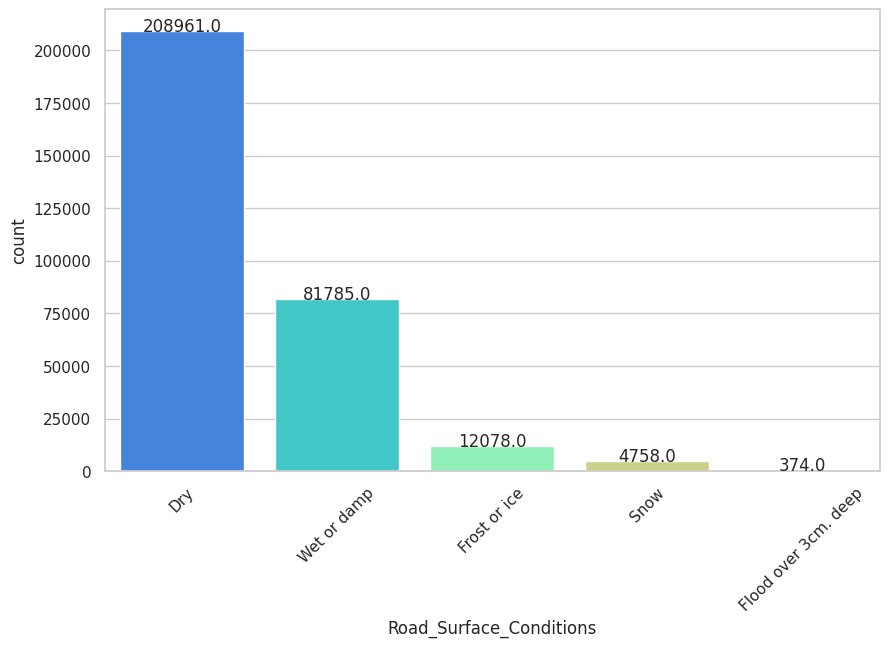

In [42]:
# visualize the distribution of categorical variables
def cnt_plot(data, col):
    plt.figure(figsize=(10, 6))
    ax1 = sns.countplot(x=col, data=data, hue=col, palette='rainbow', legend=False)

    for p in ax1.patches:
        ax1.annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + 1), ha='center')

    plt.xticks(rotation=45)  # Rotate X-axis labels
    plt.show()

    print('\n')

cnt_lst1 = ['Road_Type', 'Junction_Control',
            'Junction_Detail', 'Accident_Severity',
            'Road_Surface_Conditions']

for col in cnt_lst1:
    cnt_plot(df5, col)

### Feature Engineering

#### Feature Reduction and Selection

In [43]:
df6 = df5.copy()

In [44]:
# let's have a look at how many unique labels each feature has
# nunique() counts the unique values in every column and dropna=True argument makes sure we ignore NaN
print(df6.nunique(dropna=True).sort_values(ascending=False))

Accident_Index             307956
Longitude                  269841
Latitude                   264347
Time                         1439
Accident_Date                 730
Local_Authority               422
Police_Force                   51
Number_of_Casualties           28
Number_of_Vehicles             17
Vehicle_Type                   15
Junction_Detail                 9
Speed_limit                     8
Weather_Conditions              8
Junction_Control                7
Day_of_Week                     7
Carriageway_Hazards             6
Light_Conditions                5
Road_Surface_Conditions         5
Road_Type                       5
Accident_Severity               3
Urban_or_Rural_Area             2
dtype: int64


In [45]:
# drop the indext as it is not helpful in prediction
df6.drop('Accident_Index', axis=1, inplace=True)

#### Dimentionality reduction: Taking top X categorical features

In [46]:
df7 = df6.copy()

In [47]:
# Find the top 20 most frequent categories for the Police Force
df7.Police_Force.value_counts().sort_values(ascending=False).head(20)

,count
Police_Force,
Metropolitan Police,46789
West Midlands,13509
West Yorkshire,12016
Greater Manchester,11954
Thames Valley,11483
Kent,9995
Hampshire,9492
Lancashire,9143
Devon and Cornwall,8804


In [48]:
# Find the top 10 most frequent categories for the Vehicle_Type
df7.Vehicle_Type.value_counts().sort_values(ascending=False).head(10)

,count
Vehicle_Type,
Car,239781
Van / Goods 3.5 tonnes mgw or under,15692
Motorcycle over 500cc,11226
Bus or coach (17 or more pass seats),8686
Motorcycle 125cc and under,6852
Goods 7.5 tonnes mgw and over,6532
Taxi/Private hire car,5542
Motorcycle 50cc and under,3703
Motorcycle over 125cc and up to 500cc,3285


In [49]:
# Find the top 10 most frequent categories for the Local_Authority
df7.Local_Authority.value_counts().sort_values(ascending=False).head(10)

,count
Local_Authority,
Birmingham,6165
Leeds,4140
Manchester,3132
Bradford,3006
Westminster,2811
Sheffield,2750
Liverpool,2611
Cornwall,2606
Barnet,2302


In [50]:
# Reduced Dimension of the categorical features with high dimensionss using Top-k category technique
top_x_police_force = df7['Police_Force'].value_counts().nlargest(20).index.tolist()
top_x_veh_type = df7['Vehicle_Type'].value_counts().nlargest(10).index.tolist()
top_x_local_auth = df7['Local_Authority'].value_counts().nlargest(8).index.tolist()

In [51]:
# Save and download the top-k categories to use them later during prediction
top_k_categories = {
    'Police_Force': top_x_police_force,
    'Vehicle_Type': top_x_veh_type,
    'Local_Authority': top_x_local_auth
}
with open('top_k_categories.json', 'w') as f:
    json.dump(top_k_categories, f)

files.download('top_k_categories.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# Function to create dummy variables based on saved top-k categories
def one_hot_top_x(df7, variable, top_x_labels):
    for label in top_x_labels:
        df7[variable + '_' + label] = np.where(df7[variable] == label, 1, 0)

In [53]:
# Encode the newly-created categorical features
one_hot_top_x(df7, 'Police_Force', top_x_police_force)
one_hot_top_x(df7, 'Vehicle_Type', top_x_veh_type)
one_hot_top_x(df7, 'Local_Authority', top_x_local_auth)

In [54]:
# Drop the original columns after encoding
df7.drop(['Police_Force', 'Vehicle_Type', 'Local_Authority'], axis=1, inplace=True)

#### Handling mixed data types

In [55]:
df8 = df7.copy()

In [56]:
# Checking for features, if having mixed data types
for column in df8.columns:
    if df8[column].dtype == 'object':
        unique_types = df8[column].apply(type).unique()
        if len(unique_types) > 1:
            print(f"Column '{column}' has mixed types: {unique_types}")

Column 'Carriageway_Hazards' has mixed types: [<class 'int'> <class 'str'>]


In [57]:
# Unify the data type
for column in df8.columns:
    if df8[column].dtype == 'object':
        unique_types = df8[column].apply(type).unique()
        if len(unique_types) > 1:
            df8[column] = df8[column].astype(str)

#### Handling Dates and Times

In [58]:
df9 = df8.copy()

In [59]:
# Handling the date (to findout the wheather condition based on the dates of a year)

# Convert dates to datetime in 'DD/MM/YY' format
df9['Accident_Date'] = pd.to_datetime(df9['Accident_Date'], format='%m/%d/%Y')

# Create new columns for day, month, and year
df9['Day'] = df9['Accident_Date'].dt.day
df9['Month'] = df9['Accident_Date'].dt.month
df9['Year'] = df9['Accident_Date'].dt.year

# Remove the original 'date' column
df9.drop('Accident_Date', axis=1, inplace=True)

In [60]:
df9.Day.value_counts().sort_values(ascending=False).head(31)

,count
Day,
1,10737
23,10514
10,10480
17,10467
16,10441
12,10401
11,10389
21,10340
9,10327


In [61]:
df9.Time.value_counts().sort_values(ascending=False).head(48)

,count
Time,
17:00,2933
17:30,2834
15:30,2669
16:00,2654
18:00,2650
16:30,2549
8:30,2392
15:00,2356
14:00,2209


In [62]:
# Convert times into minutes
df9['Time'] = pd.to_datetime(df9['Time'], format='%H:%M')
# Extract hour and minute components
df9['Time_Minutes'] = df9['Time'].dt.hour * 60 + df9['Time'].dt.minute
# Now the 'Time_Minutes' column contains the total minutes
print(df9[['Time', 'Time_Minutes']])

                      Time  Time_Minutes
0      1900-01-01 15:11:00           911
1      1900-01-01 10:59:00           659
2      1900-01-01 14:19:00           859
3      1900-01-01 08:10:00           490
4      1900-01-01 17:25:00          1045
...                    ...           ...
307968 1900-01-01 07:00:00           420
307969 1900-01-01 03:00:00           180
307970 1900-01-01 09:38:00           578
307971 1900-01-01 18:25:00          1105
307972 1900-01-01 15:45:00           945

[307956 rows x 2 columns]


In [63]:
# Drop the original 'Time' column
df9.drop('Time', axis=1, inplace=True)

In [64]:
# Extract Road data as a CSV file for later use in mapping them on the map routes

# Filter the necessary columns
road_df = df9[['Latitude', 'Longitude', 'Junction_Control', 'Junction_Detail', 'Road_Type']]

# Remove rows with missing values, if any
road_df.dropna(subset=['Latitude', 'Longitude', 'Junction_Control', 'Junction_Detail', 'Road_Type'], inplace=True)

# Save processed data to a new CSV file
road_df.to_csv('road_data.csv', index=False)

# Download the CSV file
files.download('road_data.csv')

<ipython-input-64-49e29598f637>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  road_df.dropna(subset=['Latitude', 'Longitude', 'Junction_Control', 'Junction_Detail', 'Road_Type'], inplace=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
print(df9.dtypes)  # df10 is your training DataFrame

Day_of_Week                                            object
Junction_Control                                       object
Junction_Detail                                        object
Accident_Severity                                      object
Latitude                                              float64
Light_Conditions                                       object
Carriageway_Hazards                                    object
Longitude                                             float64
Number_of_Casualties                                    int64
Number_of_Vehicles                                      int64
Road_Surface_Conditions                                object
Road_Type                                              object
Speed_limit                                             int64
Urban_or_Rural_Area                                    object
Weather_Conditions                                     object
Police_Force_Metropolitan Police                        int64
Police_F

#### Lable encoding the rest of the categorical columns

In [66]:
df10 = df9.copy()

In [67]:
# The rest of the categorical columns to be label encoded
cat_cols_labling = ['Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Accident_Severity',
                    'Light_Conditions', 'Carriageway_Hazards', 'Road_Surface_Conditions',
                    'Road_Type', 'Urban_or_Rural_Area', 'Weather_Conditions']
# Create a dictionary to store the LabelEncoders
label_encoders = {}
# Encode the categorical columns and save the mappings
for feature in cat_cols_labling:
    le = LabelEncoder()
    df10[feature] = le.fit_transform(df10[feature])
    label_encoders[feature] = le

# Save the encoders for later use during prediction
joblib.dump(label_encoders, 'category_label_encoders.joblib')
files.download('category_label_encoders.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# Print the mappings for each feature
for feature, le in label_encoders.items():
    print(f"Feature: {feature}")
    print(f"Original categories: {le.classes_}")
    print(f"Encoded values: {list(range(len(le.classes_)))}")
    print()


Feature: Day_of_Week
Original categories: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
Encoded values: [0, 1, 2, 3, 4, 5, 6]

Feature: Junction_Control
Original categories: ['Authorised person' 'Auto traffic sigl' 'Auto traffic signal'
 'Data missing or out of range' 'Give way or uncontrolled'
 'Not at junction or within 20 metres' 'Stop sign']
Encoded values: [0, 1, 2, 3, 4, 5, 6]

Feature: Junction_Detail
Original categories: ['Crossroads' 'Mini-roundabout' 'More than 4 arms (not roundabout)'
 'Not at junction or within 20 metres' 'Other junction'
 'Private drive or entrance' 'Roundabout' 'Slip road'
 'T or staggered junction']
Encoded values: [0, 1, 2, 3, 4, 5, 6, 7, 8]

Feature: Accident_Severity
Original categories: ['Fatal' 'Serious' 'Slight']
Encoded values: [0, 1, 2]

Feature: Light_Conditions
Original categories: ['Darkness - lighting unknown' 'Darkness - lights lit'
 'Darkness - lights unlit' 'Darkness - no lighting' 'Daylight']
Encoded values: [0,

### Further evaluation of the data

In [69]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307956 entries, 0 to 307972
Data columns (total 57 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Day_of_Week                                         307956 non-null  int64  
 1   Junction_Control                                    307956 non-null  int64  
 2   Junction_Detail                                     307956 non-null  int64  
 3   Accident_Severity                                   307956 non-null  int64  
 4   Latitude                                            307956 non-null  float64
 5   Light_Conditions                                    307956 non-null  int64  
 6   Carriageway_Hazards                                 307956 non-null  int64  
 7   Longitude                                           307956 non-null  float64
 8   Number_of_Casualties                                307956 non-null  

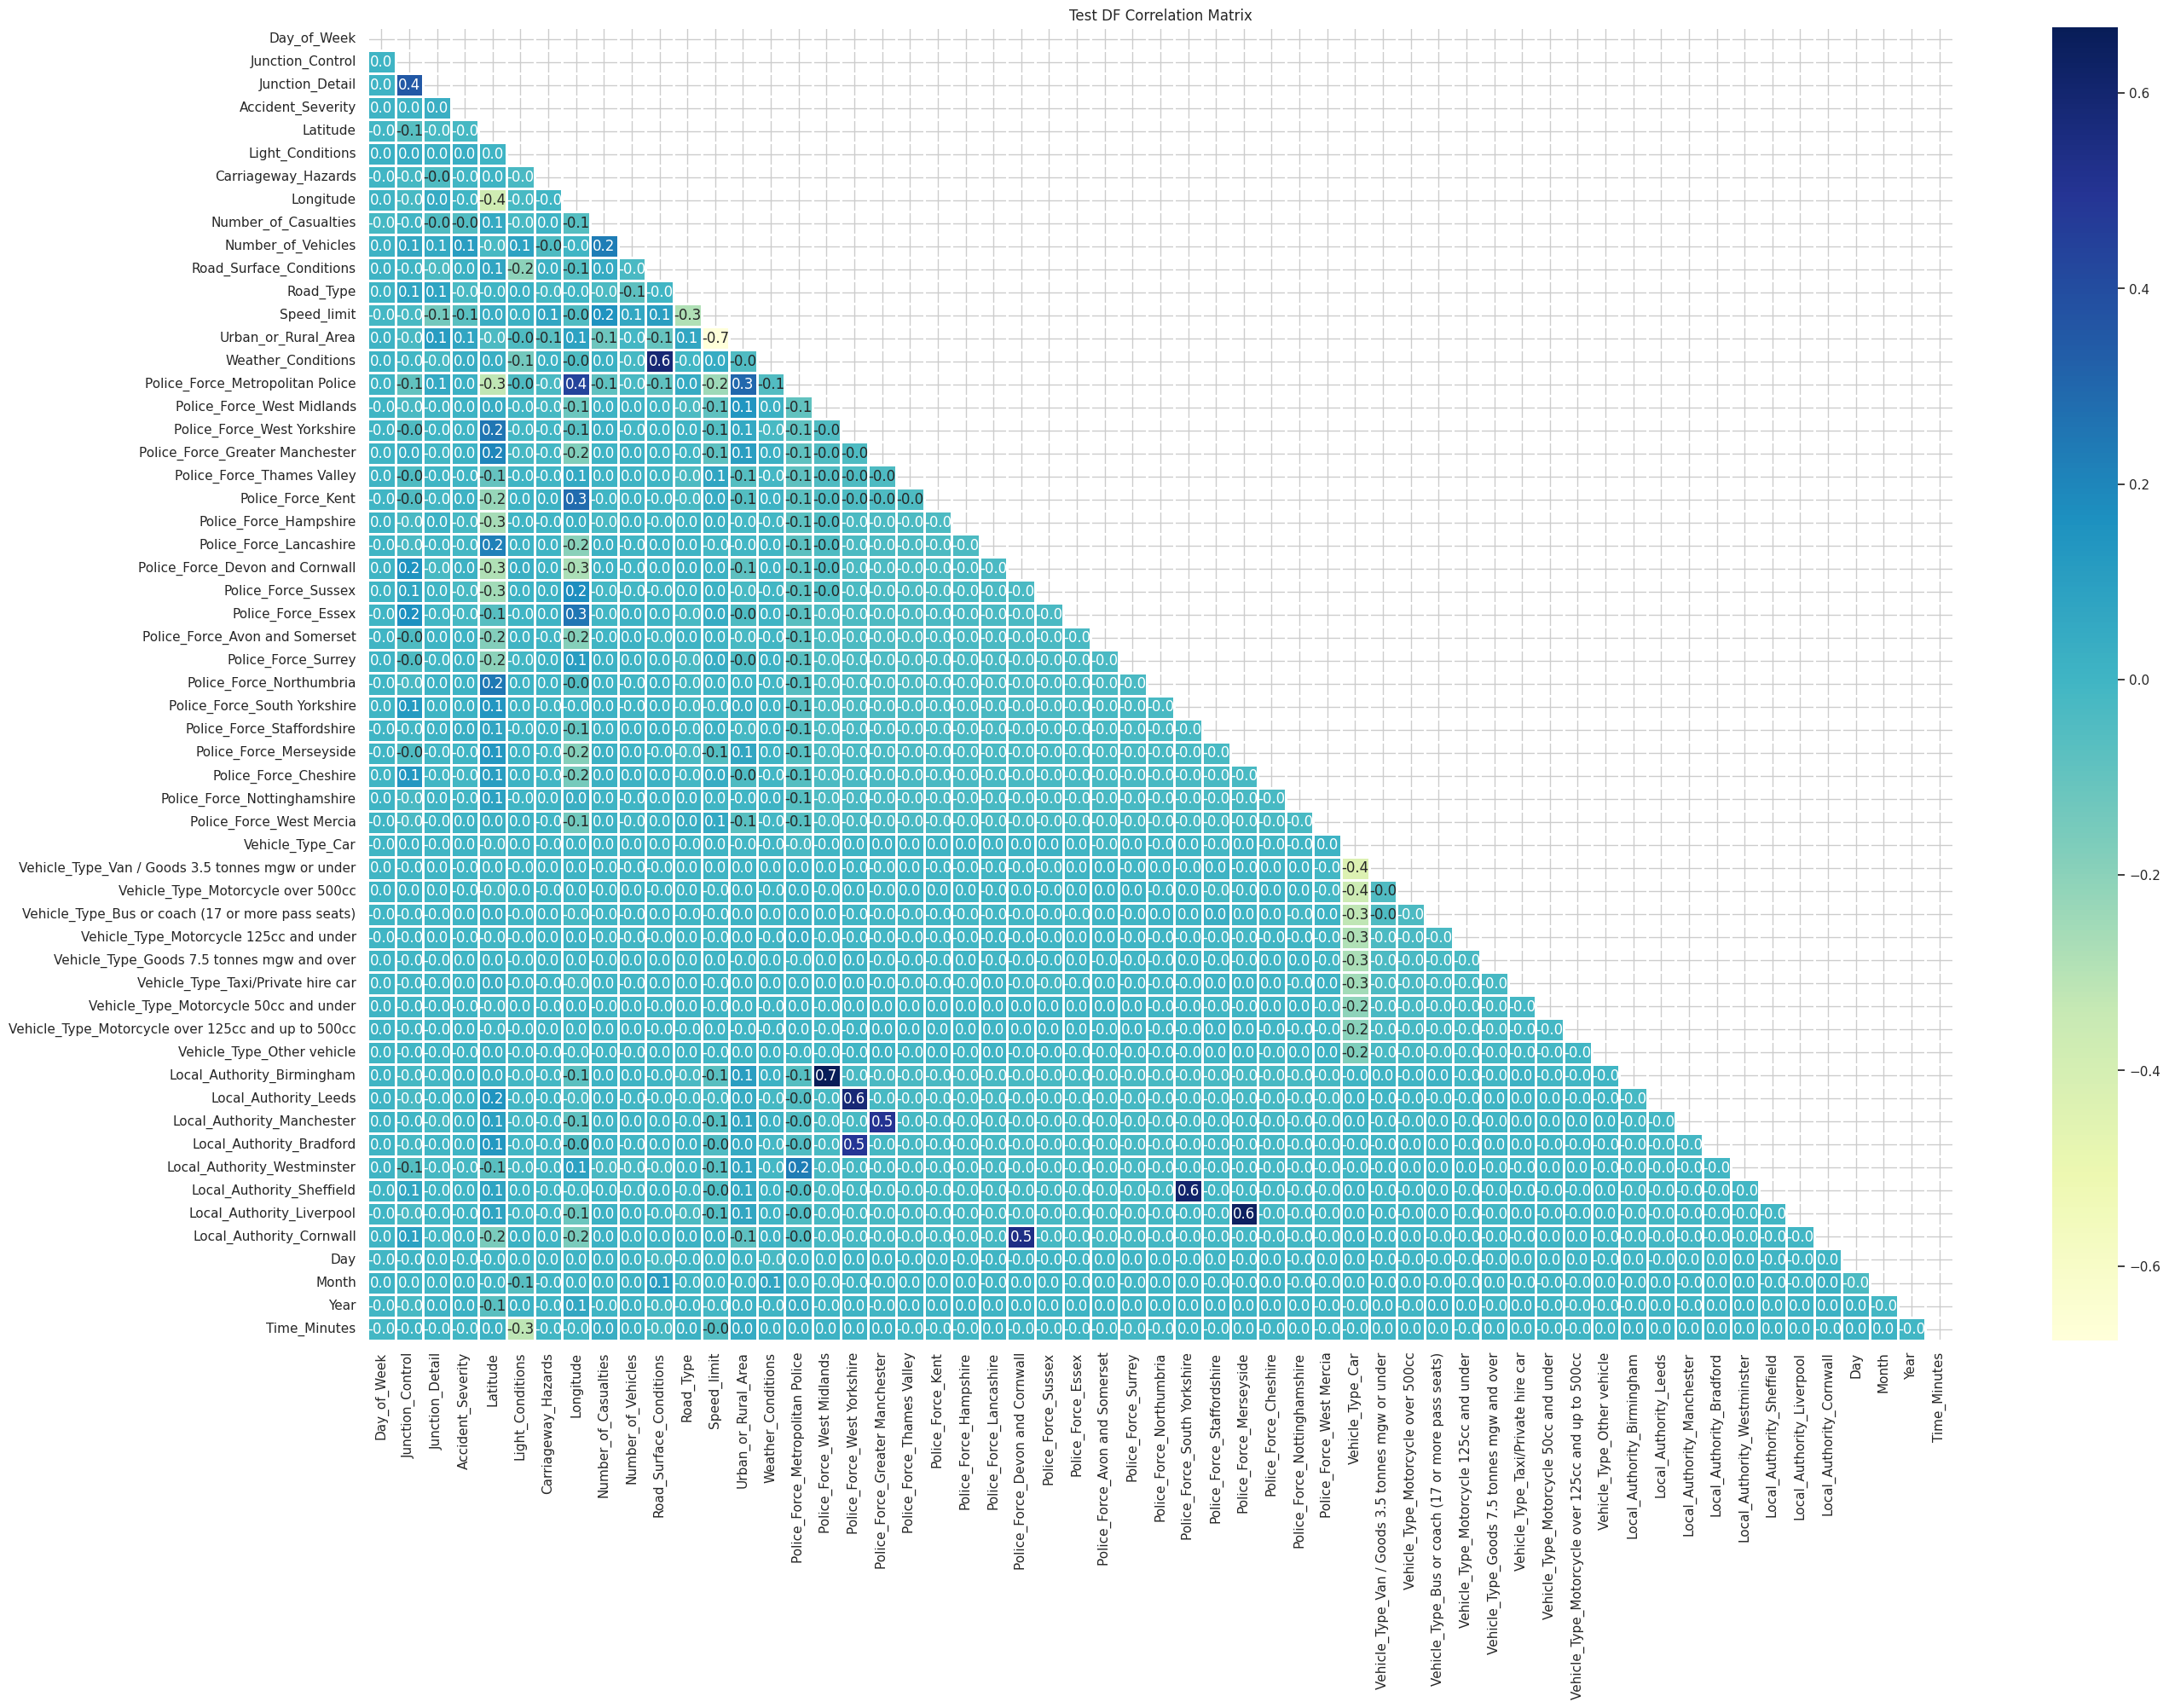

In [70]:
# Check the correlation of features using Spearman method
plt.figure(figsize = (30,20))
corr = df10.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
cormat = sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', linewidths=1, fmt=".1f")
cormat.set_title('Test DF Correlation Matrix')
#print(corr)
plt.show()

### **Tune and train the model**

In [71]:
df11 = df10.copy()

In [72]:
# Check the tearget class distribution
df11.Accident_Severity.value_counts()

,count
Accident_Severity,
2,263265
1,40738
0,3953


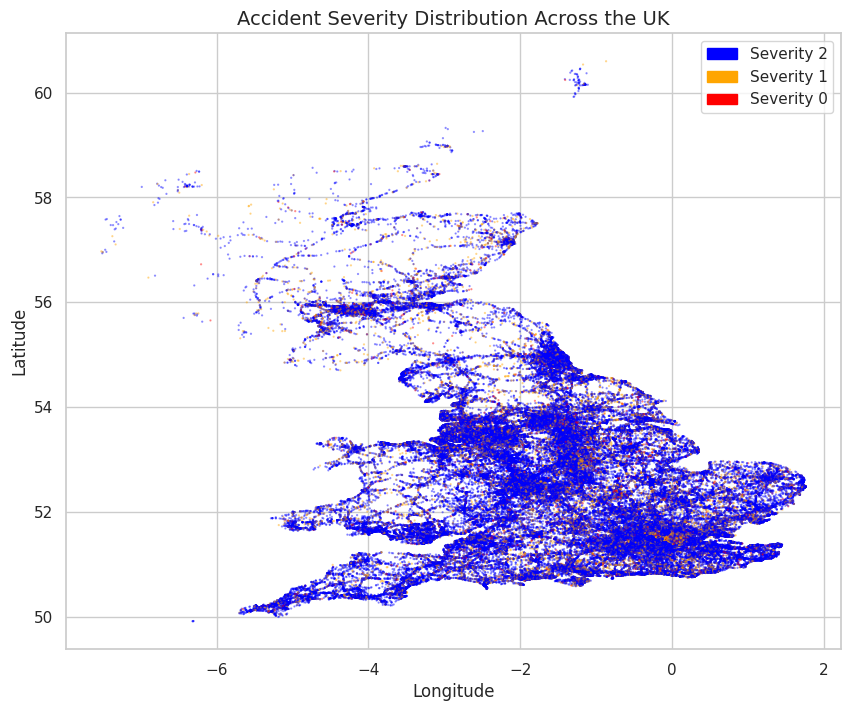

In [81]:
# Distribution of the classes
# Create a dictionary to map Accident_Severity to colors
severity_colors = {2: 'blue', 1: 'orange', 0: 'red'}

# Map the 'Accident_Severity' column to the respective colors
df11['Severity_Color'] = df11['Accident_Severity'].map(severity_colors)

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(
    df11['Longitude'],
    df11['Latitude'],
    c=df11['Severity_Color'],
    alpha=0.4,  # Set transparency
    s=0.4  # Set marker size
)

# Set the plot title and labels
plt.title('Accident Severity Distribution Across the UK', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add a legend to explain the colors
import matplotlib.patches as mpatches
legend_labels = [
    mpatches.Patch(color='blue', label='Severity 2'),
    mpatches.Patch(color='orange', label='Severity 1'),
    mpatches.Patch(color='red', label='Severity 0'),
]
plt.legend(handles=legend_labels)
plt.show()

In [ ]:
# Use a mixed sampling approach (Under- and Over Sampling) to balance the classes
X = df11.drop('Accident_Severity', axis=1)  # Features
y = df11['Accident_Severity']  # Target variable Accident_Severity

# Ensure all necessary columns are present in the dataset
if 'Police_Force_Other' not in X.columns:
    X['Police_Force_Other'] = 0
if 'Vehicle_Type_Other' not in X.columns:
    X['Vehicle_Type_Other'] = 0
if 'Local_Authority_Other' not in X.columns:
    X['Local_Authority_Other'] = 0

# Step 1: Undersample the majority class (label 2)
rus = RandomUnderSampler(sampling_strategy={2: 100000}, random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Step 2: Oversample the minority classes (labels 1 and 0)
ros = RandomOverSampler(sampling_strategy={1: 100000, 0: 100000}, random_state=42)
X_res, y_res = ros.fit_resample(X_res, y_res)


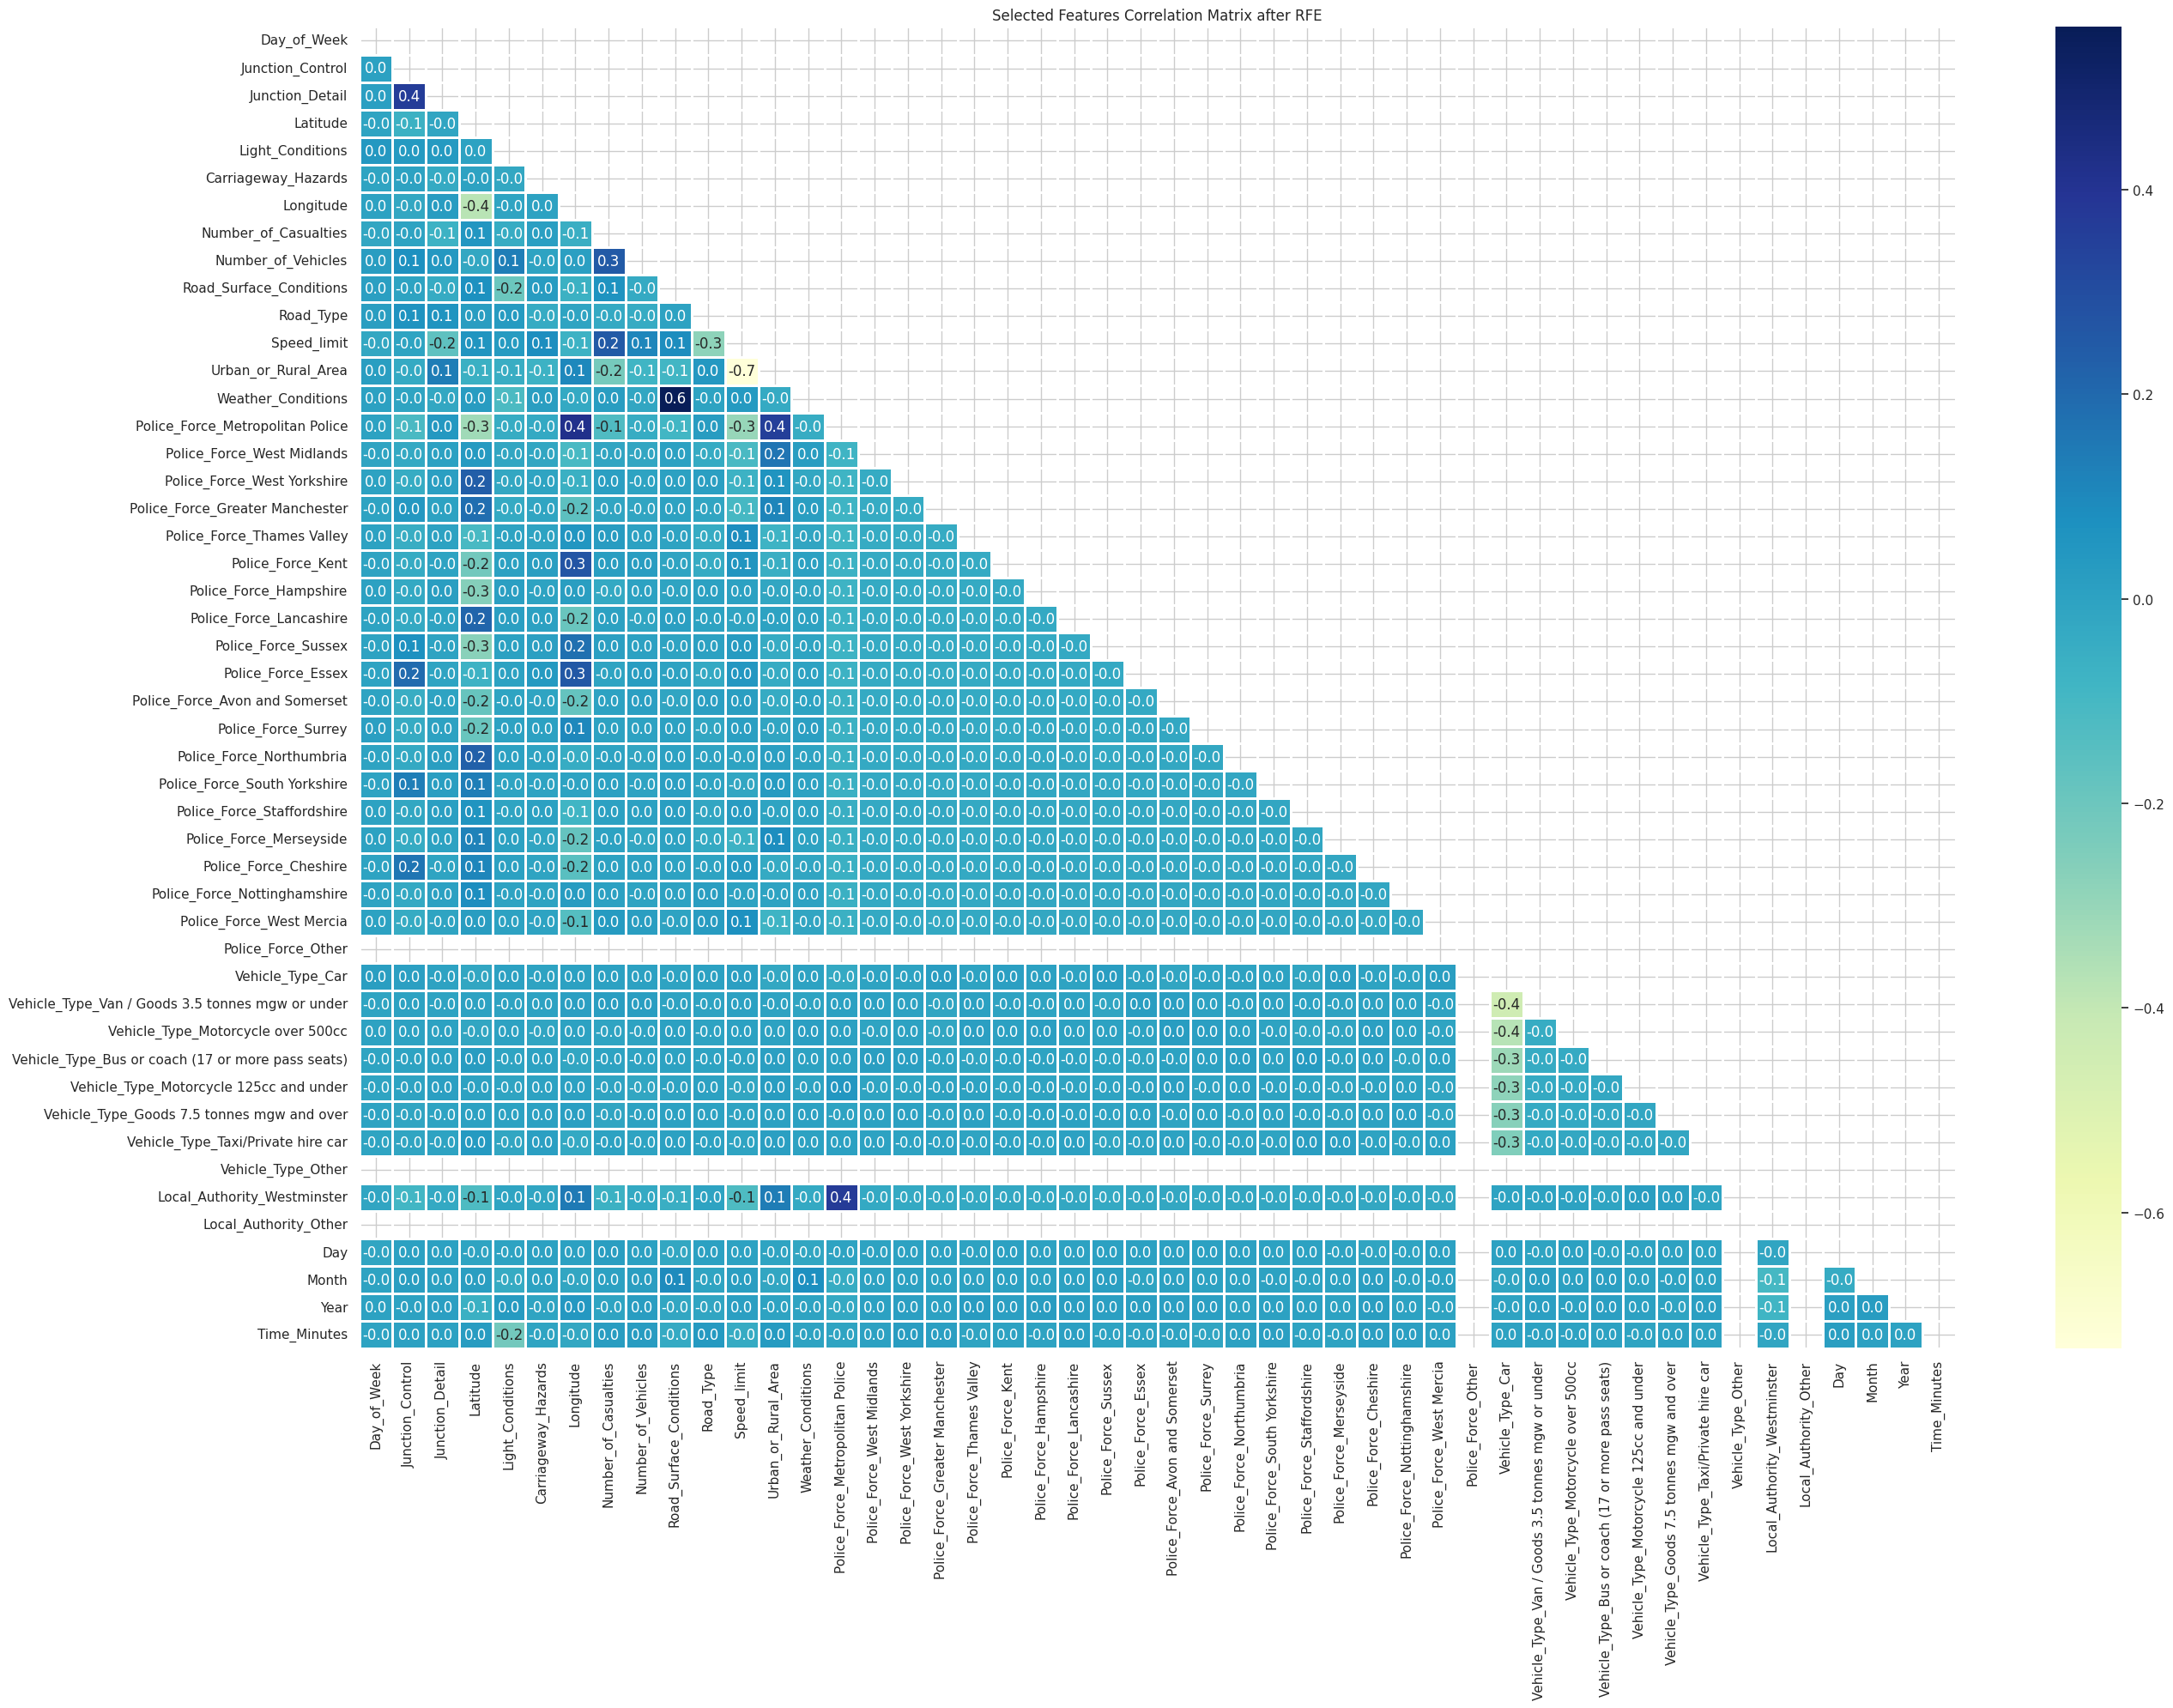

In [ ]:
# Check the correlation of features after RFE
plt.figure(figsize=(30,20))

# Compute the correlation matrix using the selected features
corr = X_res[final_selected_features].corr(method='spearman')

# Generate a mask for the upper triangle to make the heatmap clearer
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
cormat = sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', linewidths=1, fmt=".1f")
cormat.set_title('Selected Features Correlation Matrix after RFE')
plt.show()

In [ ]:
# Check the new class distribution
print(y_res.value_counts())

Accident_Severity
0    100000
1    100000
2    100000
Name: count, dtype: int64


In [ ]:
# Check the selected features after balancing
print(X_res.value_counts())

Day_of_Week  Junction_Control  Junction_Detail  Latitude   Light_Conditions  Carriageway_Hazards  Longitude  Number_of_Casualties  Number_of_Vehicles  Road_Surface_Conditions  Road_Type  Speed_limit  Urban_or_Rural_Area  Weather_Conditions  Police_Force_Metropolitan Police  Police_Force_West Midlands  Police_Force_West Yorkshire  Police_Force_Greater Manchester  Police_Force_Thames Valley  Police_Force_Kent  Police_Force_Hampshire  Police_Force_Lancashire  Police_Force_Devon and Cornwall  Police_Force_Sussex  Police_Force_Essex  Police_Force_Avon and Somerset  Police_Force_Surrey  Police_Force_Northumbria  Police_Force_South Yorkshire  Police_Force_Staffordshire  Police_Force_Merseyside  Police_Force_Cheshire  Police_Force_Nottinghamshire  Police_Force_West Mercia  Vehicle_Type_Car  Vehicle_Type_Van / Goods 3.5 tonnes mgw or under  Vehicle_Type_Motorcycle over 500cc  Vehicle_Type_Bus or coach (17 or more pass seats)  Vehicle_Type_Motorcycle 125cc and under  Vehicle_Type_Goods 7.5 tonne

In [ ]:
# Check the selected features after balancing
print(X_res.dtypes)

Day_of_Week                                             int64
Junction_Control                                        int64
Junction_Detail                                         int64
Latitude                                              float64
Light_Conditions                                        int64
Carriageway_Hazards                                     int64
Longitude                                             float64
Number_of_Casualties                                    int64
Number_of_Vehicles                                      int64
Road_Surface_Conditions                                 int64
Road_Type                                               int64
Speed_limit                                             int64
Urban_or_Rural_Area                                     int64
Weather_Conditions                                      int64
Police_Force_Metropolitan Police                        int64
Police_Force_West Midlands                              int64
Police_F

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

#### Hyperparameter tunning

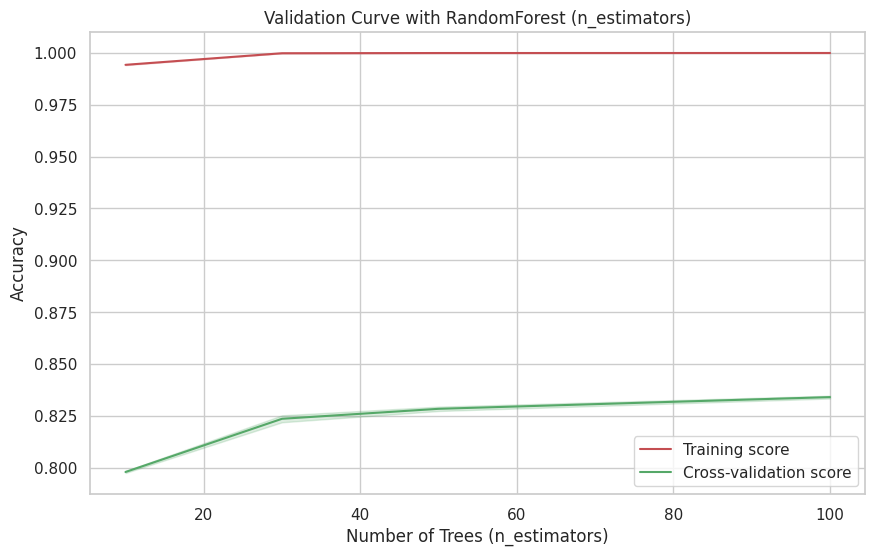

In [ ]:
from sklearn.model_selection import validation_curve

# Step 1: Define the model
model = RandomForestClassifier(random_state=42)

# Step 2: Choose a hyperparameter and define its range
param_range = [10, 30, 50, 100]  # Example for 'n_estimators'

# Step 3: Compute validation curve for the chosen hyperparameter
train_scores, test_scores = validation_curve(
    estimator=model,
    X=X_train,  # Your training data (features)
    y=y_train,  # Your training data (labels)
    param_name="n_estimators",  # Hyperparameter to test
    param_range=param_range,  # Range of values for the hyperparameter
    cv=2,  # 5-fold cross-validation
    scoring="accuracy",  # Metric to evaluate
    n_jobs=-1  # Use all available CPU cores
)

# Step 4: Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Step 5: Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="r")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.2)
plt.title("Validation Curve with RandomForest (n_estimators)")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

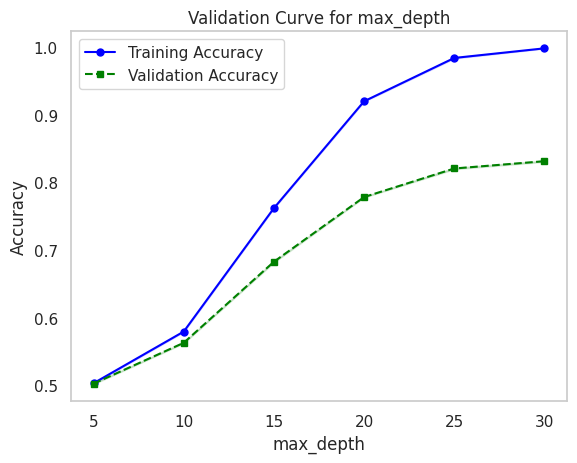

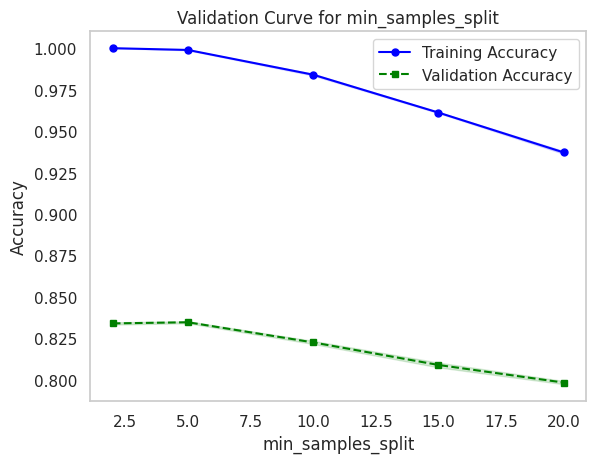

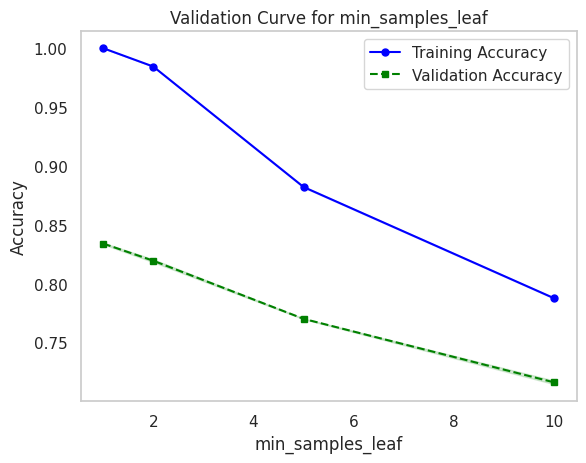

In [ ]:
# Assuming X_train and y_train are already defined
# Initialize the RandomForest model
model = RandomForestClassifier(random_state=42)

# Function to plot the validation curve
def plot_validation_curve(train_scores, test_scores, param_range, param_name):
    # Calculate mean and standard deviation of training and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
    plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='green', alpha=0.15)

    plt.title(f'Validation Curve for {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

# ============================
# Tuning `max_depth`
# ============================

param_range = [5, 10, 15, 20, 25, 30]
train_scores, test_scores = validation_curve(
    estimator=model,
    X=X_train, y=y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=2, scoring="accuracy", n_jobs=-1)

# Plot the validation curve for max_depth
plot_validation_curve(train_scores, test_scores, param_range, 'max_depth')

# ============================
# Tuning `min_samples_split`
# ============================
param_range = [2, 5, 10, 15, 20]
train_scores, test_scores = validation_curve(
    estimator=model,
    X=X_train, y=y_train,
    param_name="min_samples_split",
    param_range=param_range,
    cv=2, scoring="accuracy", n_jobs=-1)

# Plot the validation curve for min_samples_split
plot_validation_curve(train_scores, test_scores, param_range, 'min_samples_split')


param_range = [1, 2, 5, 10]
train_scores, test_scores = validation_curve(
    estimator=model,
    X=X_train, y=y_train,
    param_name="min_samples_leaf",
    param_range=param_range,
    cv=2, scoring="accuracy", n_jobs=-1)

# Plot the validation curve for min_samples_leaf
plot_validation_curve(train_scores, test_scores, param_range, 'min_samples_leaf')

In [ ]:
# Optimal hyperparameters from cross-validation
optimal_n_estimators = 40  # Based on validation curve for n_estimators
optimal_max_depth = 28  # Based on validation curve for max_depth or 22
optimal_min_samples_split = 3  # Based on validation curve for min_samples_split
optimal_min_samples_leaf = 2  # Based on validation curve for min_samples_leaf

# Adjust class weights based on the imbalance in the original dataset
#class_weights = {0: 1, 1: 2, 2: 4}  # Inverse of class frequency
#class_weights = {0: 263265/3953, 1: 263265/40738, 2: 1}  # Inverse of class frequency

# Initialize the RandomForestClassifier with optimal hyperparameters and class weights
model = RandomForestClassifier(
    n_estimators=optimal_n_estimators,
    max_depth=optimal_max_depth,
    min_samples_split=optimal_min_samples_split,
    min_samples_leaf=optimal_min_samples_leaf,  # Include min_samples_leaf here
    #class_weight=class_weights,  # Include class weights
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Define the must-keep features
must_keep_features = {
    'Police_Force_Other': 'Police_Force_',
    'Vehicle_Type_Other': 'Vehicle_Type_',
    'Local_Authority_Other': 'Local_Authority_'
}

# Separate feature groups
police_force_features = [col for col in X_train.columns if col.startswith('Police_Force_') and col != 'Police_Force_Other']
vehicle_type_features = [col for col in X_train.columns if col.startswith('Vehicle_Type_') and col != 'Vehicle_Type_Other']
local_authority_features = [col for col in X_train.columns if col.startswith('Local_Authority_') and col != 'Local_Authority_Other']

# Remove must-keep features before applying RFE
X_train_filtered = X_train.drop(columns=list(must_keep_features.keys()))

In [ ]:
# Fit RFE to the training data
rfe = RFE(estimator=model, n_features_to_select=48 - len(must_keep_features))  # Subtract the number of must-keep features
rfe.fit(X_train_filtered, y_train)

RFE(estimator=RandomForestClassifier(max_depth=28, min_samples_leaf=2,
                                     min_samples_split=3, n_estimators=40,
                                     n_jobs=-1, random_state=42),
    n_features_to_select=45)

In [ ]:
# Get the selected features from RFE
selected_features_rfe = X_train_filtered.columns[rfe.support_].tolist()
rankings = rfe.ranking_

# Print the selected features and their rankings
print("Selected Features:", selected_features_rfe)
print("Feature Rankings:", rankings)

Selected Features: ['Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Carriageway_Hazards', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Police_Force_Metropolitan Police', 'Police_Force_West Midlands', 'Police_Force_West Yorkshire', 'Police_Force_Greater Manchester', 'Police_Force_Thames Valley', 'Police_Force_Kent', 'Police_Force_Hampshire', 'Police_Force_Lancashire', 'Police_Force_Sussex', 'Police_Force_Essex', 'Police_Force_Avon and Somerset', 'Police_Force_Surrey', 'Police_Force_Northumbria', 'Police_Force_South Yorkshire', 'Police_Force_Staffordshire', 'Police_Force_Merseyside', 'Police_Force_Cheshire', 'Police_Force_Nottinghamshire', 'Police_Force_West Mercia', 'Vehicle_Type_Car', 'Vehicle_Type_Van / Goods 3.5 tonnes mgw or under', 'Vehicle_Type_Motorcycle over 500cc', 'Vehicle_Type_Bus or coach (17 or more pass seats)', 'Vehicle_

In [ ]:
# Combine the RFE-selected features with must-keep features
final_selected_features = selected_features_rfe.copy()  # Start with RFE-selected features

# Function to insert the "Other" feature after the last respective group feature (only once)
def insert_other_feature_once(feature_list, other_feature, group_features):
    # Find the index of the last feature in the group
    last_group_feature_idx = max([feature_list.index(f) for f in group_features if f in feature_list], default=-1)
    # Insert the "Other" feature immediately after the last feature in the group if it's not already in the list
    if last_group_feature_idx != -1 and other_feature not in feature_list:
        feature_list.insert(last_group_feature_idx + 1, other_feature)

# Insert the must-keep "Other" features in the correct order
insert_other_feature_once(final_selected_features, 'Police_Force_Other', police_force_features)
insert_other_feature_once(final_selected_features, 'Vehicle_Type_Other', vehicle_type_features)
insert_other_feature_once(final_selected_features, 'Local_Authority_Other', local_authority_features)

# Output the final selected features for confirmation
print("Final Selected Features:", final_selected_features)


Final Selected Features: ['Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Carriageway_Hazards', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Police_Force_Metropolitan Police', 'Police_Force_West Midlands', 'Police_Force_West Yorkshire', 'Police_Force_Greater Manchester', 'Police_Force_Thames Valley', 'Police_Force_Kent', 'Police_Force_Hampshire', 'Police_Force_Lancashire', 'Police_Force_Sussex', 'Police_Force_Essex', 'Police_Force_Avon and Somerset', 'Police_Force_Surrey', 'Police_Force_Northumbria', 'Police_Force_South Yorkshire', 'Police_Force_Staffordshire', 'Police_Force_Merseyside', 'Police_Force_Cheshire', 'Police_Force_Nottinghamshire', 'Police_Force_West Mercia', 'Police_Force_Other', 'Vehicle_Type_Car', 'Vehicle_Type_Van / Goods 3.5 tonnes mgw or under', 'Vehicle_Type_Motorcycle over 500cc', 'Vehicle_Type_Bus or coach (17 or 

In [ ]:
# Convert list to pandas Series and count occurrences to confirm the number of unique features
final_selected_features_series = pd.Series(final_selected_features)
print("Final Selected Features with counts:")
print(final_selected_features_series.nunique())  # Ensure we don't have duplicate features

Final Selected Features with counts:
48


In [ ]:
# Train the model with the final selected features
X_train_rfe = X_train[final_selected_features]  # Use the final selected features with 'Other' fields inserted
X_test_rfe = X_test[final_selected_features]    # Apply the same for test data

# Refit the model
model.fit(X_train_rfe, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test_rfe)

In [ ]:
# Results received from Classes balanced equally
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20101
           1       0.79      0.81      0.80     19929
           2       0.81      0.77      0.79     19970

    accuracy                           0.86     60000
   macro avg       0.86      0.86      0.86     60000
weighted avg       0.86      0.86      0.86     60000



In [ ]:
# Create the JSON file from latest independent features for later use in real-life prediction
columns = {
    'data_columns': final_selected_features
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))
files.download("columns.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

# Assuming X_train_rfe contains the features used for training the model
important_features = pd.Series(feature_importances, index=X_train_rfe.columns).sort_values(ascending=False)

# Print or visualize the most important features
print("Important Features and their Importance Scores:")
print(important_features)

Important Features and their Importance Scores:
Time_Minutes                                         0.122294
Longitude                                            0.117814
Latitude                                             0.116898
Day                                                  0.089324
Month                                                0.073708
Day_of_Week                                          0.055823
Speed_limit                                          0.041781
Number_of_Vehicles                                   0.041377
Number_of_Casualties                                 0.034797
Junction_Detail                                      0.033431
Urban_or_Rural_Area                                  0.023815
Junction_Control                                     0.022323
Year                                                 0.021076
Weather_Conditions                                   0.020541
Road_Type                                            0.019809
Road_Surface_Condition

### **Validate the model**

Accuracy: 0.86095
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     20101
           1       0.79      0.81      0.80     19929
           2       0.81      0.77      0.79     19970

    accuracy                           0.86     60000
   macro avg       0.86      0.86      0.86     60000
weighted avg       0.86      0.86      0.86     60000

Confusion Matrix:
 [[20091     0    10]
 [  125 16231  3573]
 [  211  4424 15335]]


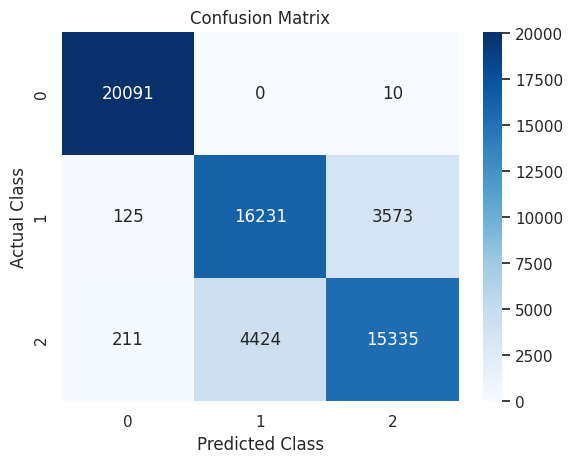

In [ ]:
# Evaluate the model's performance on the test data
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optionally, plot the confusion matrix for better visualization
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
# Calculate accuracy on the training set
y_train_pred = model.predict(X_train_rfe)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')

# Calculate accuracy on the test set
y_test_pred = model.predict(X_test_rfe)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')


Training Accuracy: 0.9698416666666667
Test Accuracy: 0.86095


In [ ]:
scores = cross_val_score(model, X_res[final_selected_features], y_res, cv=5)
print(f"Cross-Validation Accuracy: {scores.mean()}")

In [ ]:
# Perform cross-validation with the model (using balanced data from X_train_rfe, y_train)
cv_scores = cross_val_score(model, X_train_rfe, y_train, cv=5, scoring='accuracy')  # Using 5-fold cross-validation

# Output the cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

### **Download or Deploy Model**

In [ ]:
# Save the model using joblib for more efficient serialization
joblib.dump(model, 'model.joblib', compress=2)

# Download the compressed model file
files.download('model.joblib')

In [ ]:
df11.to_csv('cleaned_data.csv', index=False)

# Download the file (this will generate a download link in Colab)
files.download('cleaned_data.csv')

In [ ]:
final_selected_features.to_csv('selected_features.csv', index=False)

# Download the file (this will generate a download link in Colab)
files.download('selected_features.csv')

## Extra works

In [ ]:
df11.head()

In [ ]:
# Extract Latitude, Longitude, and Accident_Severity as a CSV file for later use in mapping the accidents on the map routes

severity_mapping = {'Fatal': 0, 'Serious': 1, 'Slight': 2}
df2['Severity_Code'] = df2['Accident_Severity'].map(severity_mapping)

# Filter the necessary columns
filtered_df = df2[['Latitude', 'Longitude', 'Severity_Code']]

# Remove rows with missing values, if any
filtered_df.dropna(subset=['Latitude', 'Longitude', 'Severity_Code'], inplace=True)

# Display the processed data
print(filtered_df.head())


In [ ]:
# Save processed data to a new CSV file
filtered_df.to_csv('coordinates.csv', index=False)

# Download the CSV file
files.download('coordinates.csv')

In [ ]:
# Extract Road data as a CSV file for later use in mapping them on the map routes

# Filter the necessary columns
road_df = df11[['Latitude', 'Longitude', 'Junction_Control', 'Junction_Detail', 'Carriageway_Hazards', 'Road_Type', 'Speed_limit']]

# Remove rows with missing values, if any
road_df.dropna(subset=['Latitude', 'Longitude', 'Junction_Control', 'Junction_Detail', 'Carriageway_Hazards', 'Road_Type', 'Speed_limit'], inplace=True)

# Save processed data to a new CSV file
road_df.to_csv('road_data.csv', index=False)

# Download the CSV file
files.download('road_data.csv')